In [51]:
#My default packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from dataclasses import dataclass
import itertools
import heapq


# Day 15

In [52]:
with open("input15.txt") as f:
    sensfile = f.readlines()

with open("ex15.txt") as f:
    exsensfile = f.readlines()

In [59]:
@dataclass
class Point:
    x : int
    y : int

    @property
    def u(self):
        return self.x+self.y

    @property
    def v(self):
        return self.x-self.y

    def __hash__(self) -> int:
        return hash((self.x,self.y))

    def Manhattan(self,b):
        return  abs(self.x-b.x)+abs(self.y-b.y)

    def tuningfrequency(self):
        return 4000000*self.x+self.y

class NaiveExclusionZone(dict):
    "The exclusion zone is a dictionary where the key is the y coordinate and the forbidden regions are the ranges in a list of tuple"

    def add(self,new):
        "Inplace into self"
        for yn in new.keys():
            for rn in new[yn]:
                self.addrange(yn,rn)

    def addrange(self,y,xr):
        "xr is a tuple representing a range"
        try:
            for k,oxr in enumerate(self[y]):
                if not ((oxr[0]>xr[1]) or (xr[0]>oxr[1])): #overlap
                    self[y].pop(k)
                    self.addrange(y,(min(oxr[0],xr[0]),max(oxr[1],xr[1])))
                    return None
            self[y].append(xr)
        except KeyError:
            self[y] = [xr]

    def excludedpoints(self,y=None):
        if y is None:
            res = 0
            for y in self.keys(): res+= self.excludedpoints(y)
            return res
        else:
            res = 0
            try:
                for xr in self[y]:
                    res += xr[1]-xr[0]+1
            except KeyError: pass
            return res

@dataclass
class Beacon(Point):
    def __hash__(self) -> int:
        return hash((self.x,self.y))

@dataclass
class Sensor(Point):
    b : Beacon
    
    def __hash__(self) -> int:
        return hash((self.x,self.y,hash(self.b)))
    @property
    def excludedradius(self):
        return self.Manhattan(self.b)

    @classmethod
    def frominput(cls,line):
        import re
        x,y,xb,yb = map(int,re.findall(r"-\d+|\d+",line))
        beacon = Beacon(xb,yb)
        return  Sensor(x,y,beacon)

    def naiveexclusionzone(self,y=None):
        Md = self.excludedradius
        ez = NaiveExclusionZone()
        if y is None:
            for k in range(Md+1):
                ez.addrange(self.y+k,(self.x-(Md-k),self.x+Md-k))
                ez.addrange(self.y-k,(self.x-(Md-k),self.x+Md-k))
        else:
            if abs(self.y-y)<=Md:
                ez.addrange(y,(self.x-(Md-abs(self.y-y)),self.x+(Md-abs(self.y-y))))
        return ez




In [60]:
sensors = [Sensor.frominput(l) for l in sensfile]
beacons = set(s.b for s in sensors)

In [61]:
exsen = [Sensor.frominput(l) for l in exsensfile]

In [62]:
EZ = NaiveExclusionZone()
for s in sensors:
    EZ.add(s.naiveexclusionzone(y=2000000))
EZ.excludedpoints(y=2000000)-len([b for b in beacons if b.y==2000000])

5511201

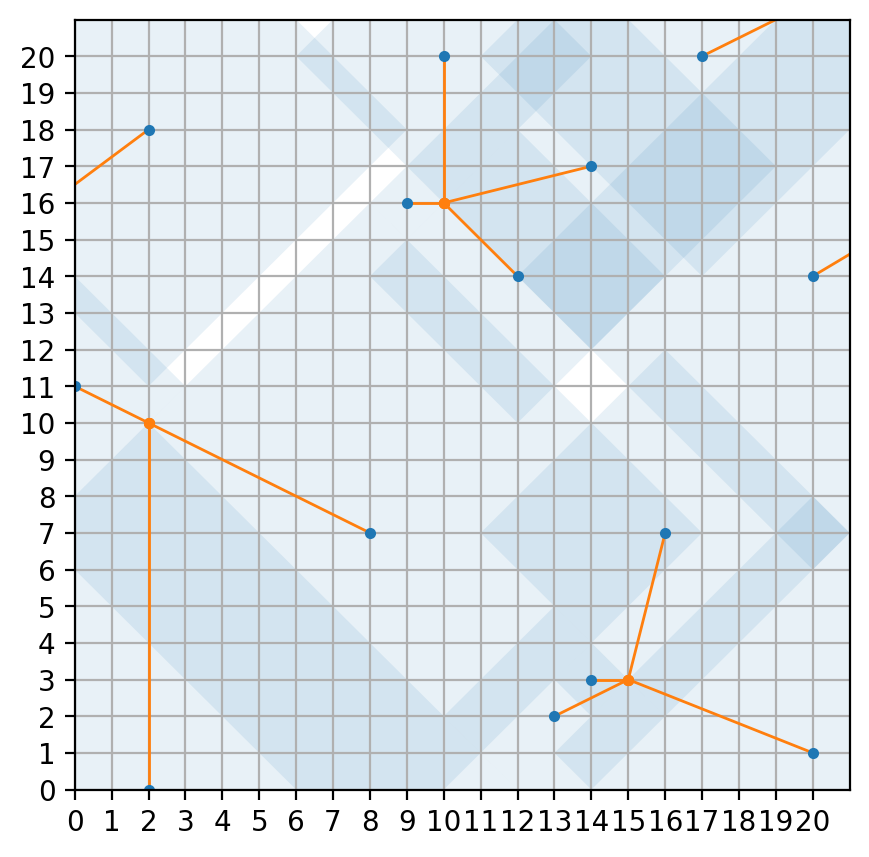

In [66]:

fig,ax = plt.subplots(figsize=(5,5))
ax.set_xlim(0,21)
ax.set_ylim(0,21)
for s in exsen:
    ax.plot([s.x,s.b.x],[s.y,s.b.y],c="tab:orange",lw=1)
    ax.fill_between([s.x-s.excludedradius,s.x,s.x+s.excludedradius],[s.y,s.y+s.excludedradius,s.y],[s.y,s.y-s.excludedradius,s.y],color="tab:blue",edgecolor=None,alpha=0.1)
ax.plot([s.x for s in exsen],[s.y for s in exsen],'.')

plt.plot([s.b.x for s in exsen],[s.b.y for s in exsen],'.')
plt.xticks(np.arange(21))
plt.yticks(np.arange(21))
plt.grid("on")

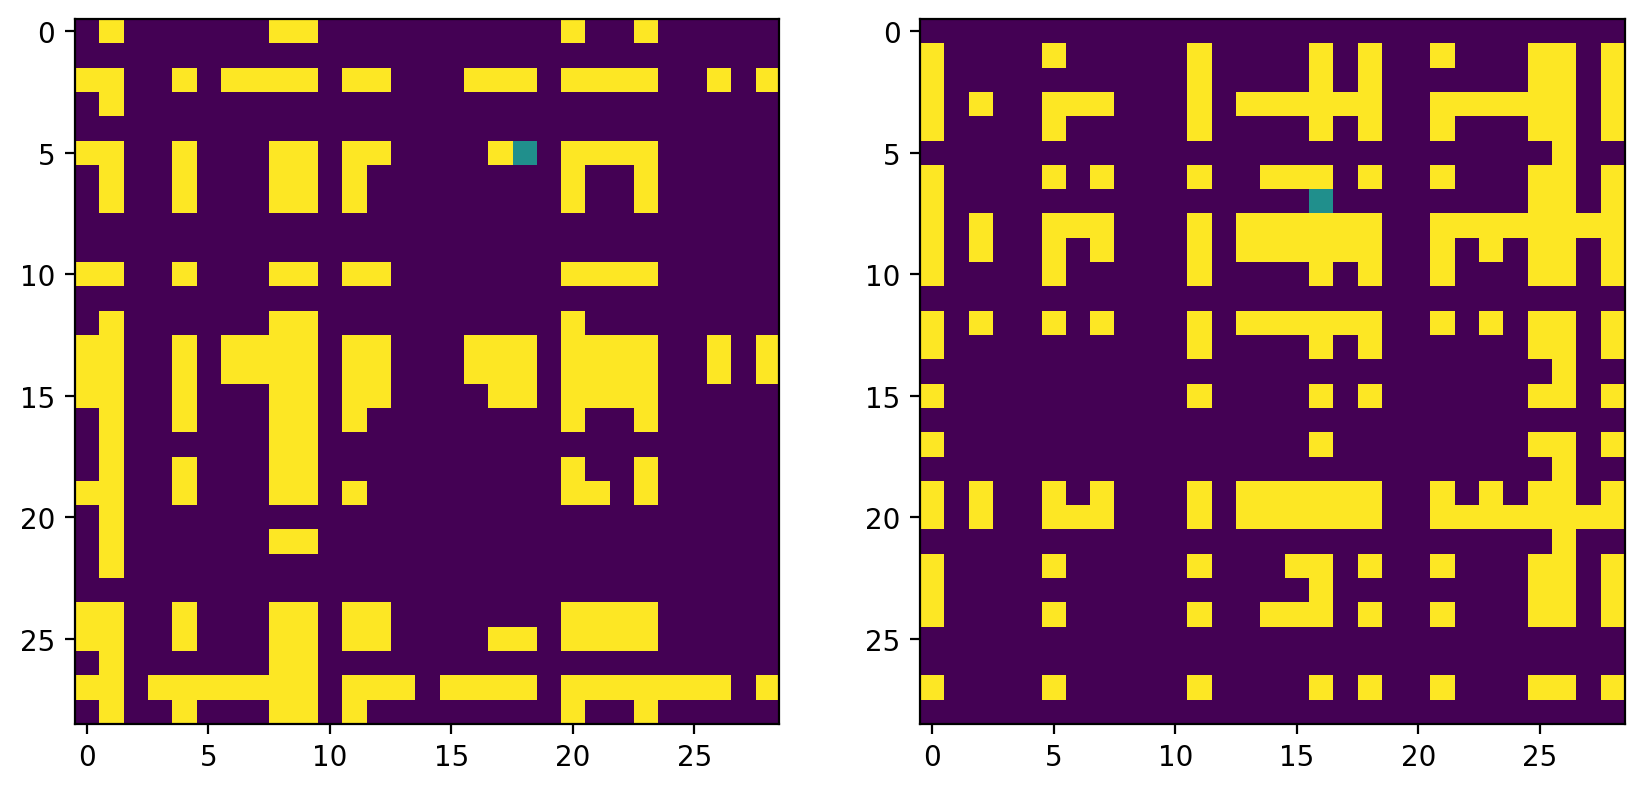

In [67]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow([[(s1.v-s1.excludedradius)-(s2.v+s2.excludedradius)-2 for s1 in sensors] for s2 in sensors],vmin=-1,vmax=1)
im = axs[1].imshow([[(s1.u-s1.excludedradius)-(s2.u+s2.excludedradius)-2 for s1 in sensors] for s2 in sensors],vmin=-1,vmax=1)


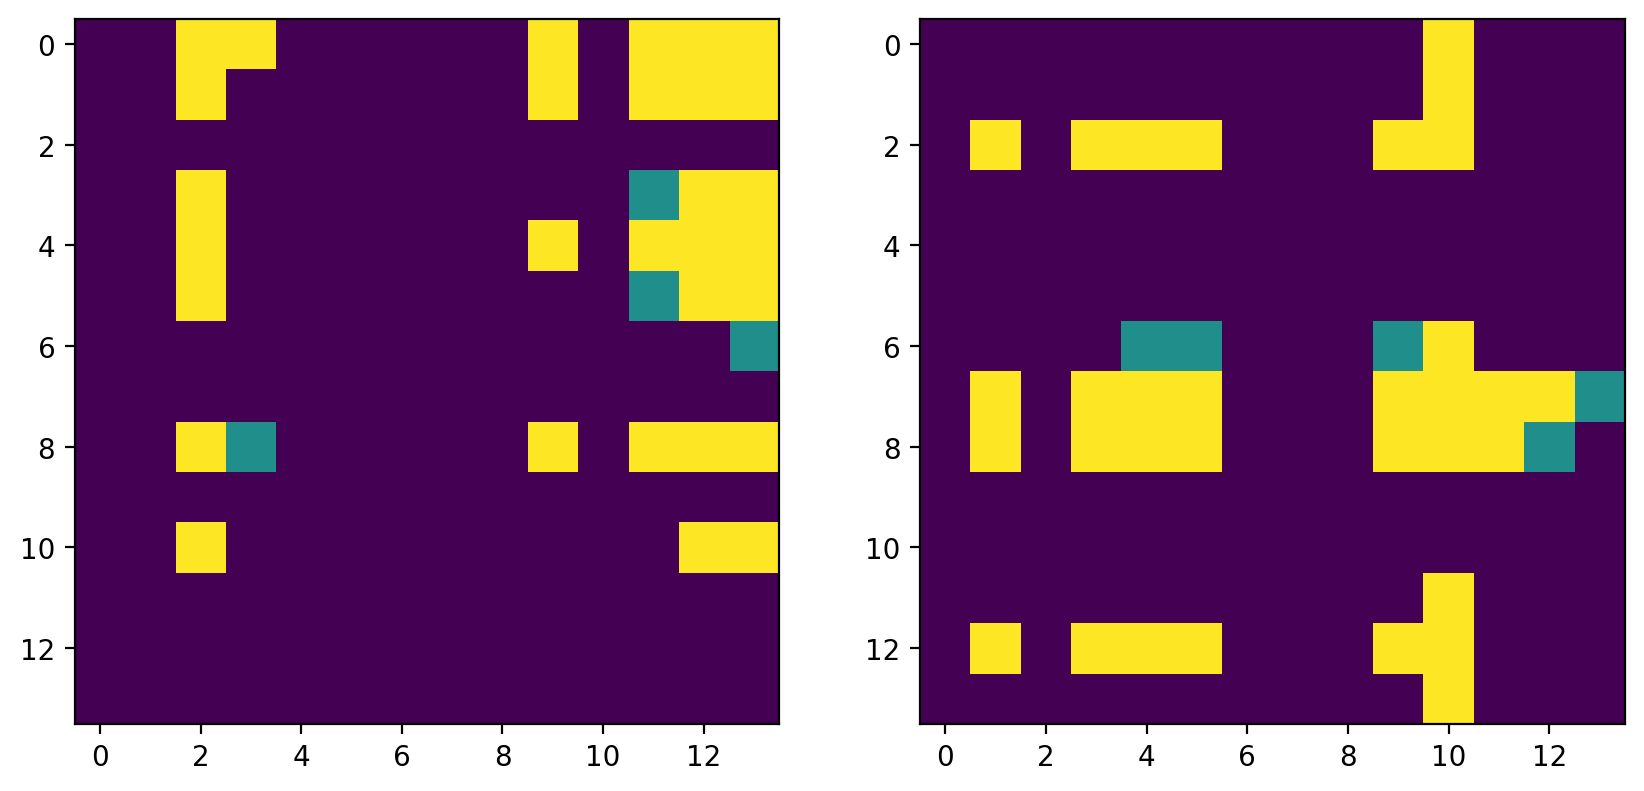

In [68]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow([[(s1.v-s1.excludedradius)-(s2.v+s2.excludedradius)-2 for s1 in exsen] for s2 in exsen],vmin=-1,vmax=1)
im = axs[1].imshow([[(s1.u-s1.excludedradius)-(s2.u+s2.excludedradius)-2 for s1 in exsen] for s2 in exsen],vmin=-1,vmax=1)

In [69]:

for s1,s2 in itertools.product(sensors,repeat=2):
    if ((s1.v-s1.excludedradius-1)==(s2.v+s2.excludedradius)+1):
        holev = s1,s2
    elif ((s1.u-s1.excludedradius-1)==(s2.u+s2.excludedradius)+1):
        holeu = s1,s2
beaconu = holeu[0].u-holeu[0].excludedradius-1
beaconv = holev[0].v-holev[0].excludedradius-1

beacon = Beacon((beaconu+beaconv)//2,(beaconu-beaconv)//2)
beacon.tuningfrequency()

11318723411840

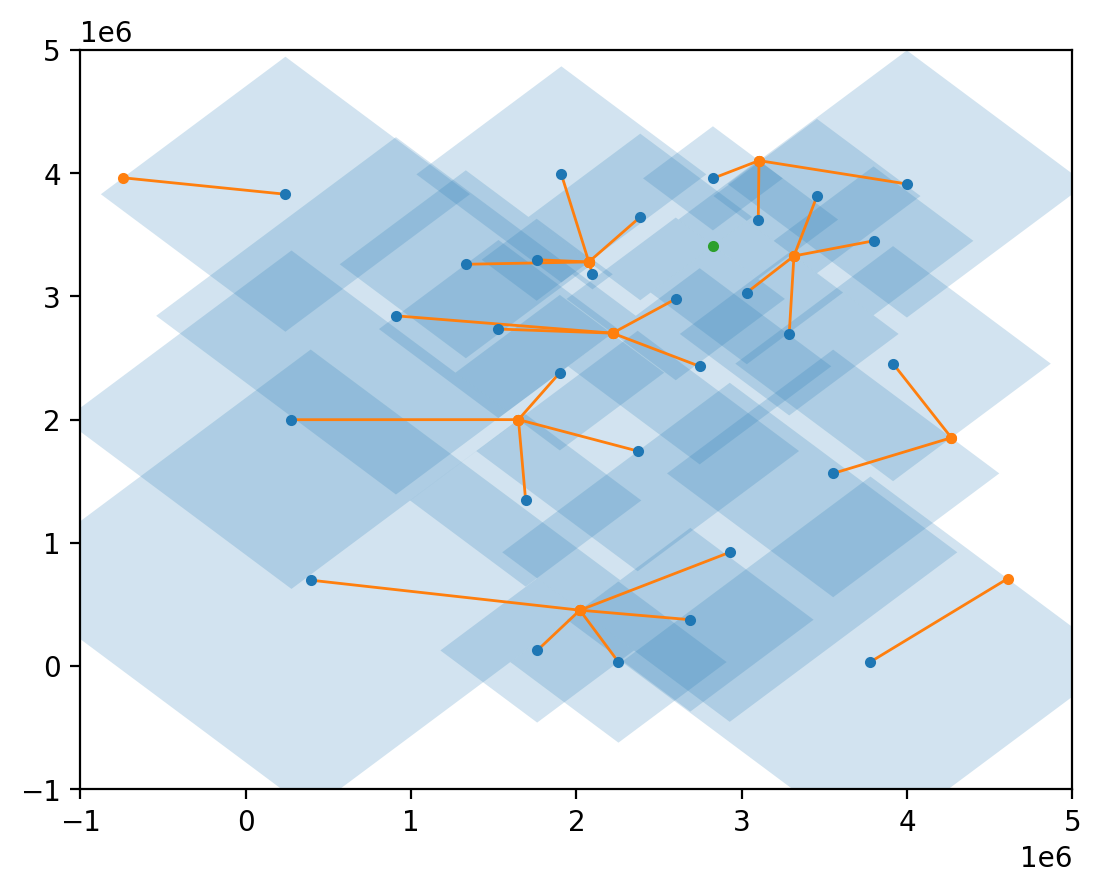

In [70]:
plt.xlim(-1000000,5000000)
plt.ylim(-1000000,5000000)
for s in sensors:
    plt.plot([s.x,s.b.x],[s.y,s.b.y],c="tab:orange",lw=1)
    plt.fill_between([s.x-s.excludedradius,s.x,s.x+s.excludedradius],[s.y,s.y+s.excludedradius,s.y],[s.y,s.y-s.excludedradius,s.y],color="tab:blue",edgecolor=None,alpha=0.2)
plt.plot([s.x for s in sensors],[s.y for s in sensors],'.')

plt.plot([s.b.x for s in sensors],[s.b.y for s in sensors],'.')
plt.plot(beacon.x,beacon.y,'.')

In [71]:
#Does not work in the example because too many coordinates fit the criterion
for s1,s2 in itertools.product(exsen,repeat=2):
    if ((s1.v-s1.excludedradius-1)==(s2.v+s2.excludedradius)+1) and abs(s1.u-s2.u)<s1.excludedradius+s2.excludedradius-1:
        holev = s1,s2
    elif ((s1.u-s1.excludedradius-1)==(s2.u+s2.excludedradius)+1) and abs(s1.v-s2.v)<s1.excludedradius+s2.excludedradius-1:
        holeu = s1,s2
beaconu = holeu[0].u-holeu[0].excludedradius-1
beaconv = holev[0].v-holev[0].excludedradius-1

beacon = Beacon((beaconu+beaconv)//2,(beaconu-beaconv)//2)
beacon.tuningfrequency()

72000007